In [6]:


import torch
CUDA = torch.cuda.is_available()
print(CUDA)

True


In [7]:
import time
from lifelines.utils import concordance_index 
import sys
from torch import nn
import numpy as np
import pandas as pd
import network
from torch.utils.data import TensorDataset, Dataset
import torch.utils.data.dataloader as dataloader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


ds = pd.read_csv('./datasets/whas500.csv',sep=',')
# ds = pd.read_csv('./datasets/whas1638.csv',sep=',')
train = ds
# train = ds[:400]
# validation = ds[400:]

x = train[['age', 'gender', 'bmi', 'chf', 'miord']]
# x = train[['1', '2', '3', '4', '5']]
e = train['fstat']
t = train['lenfol']

x = torch.from_numpy(x.as_matrix()).float()
e = torch.from_numpy(e.as_matrix()).float()
t = torch.from_numpy(t.as_matrix())

In [8]:
if CUDA:
    x = x.cuda()
    e = e.cuda()
    t = t.cuda()

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
#         m.weight.data.fill_(0)
#         m.bias.data.fill_(1)

def init_weights_for_cox(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)
        
print("starting risk set computation...")
risk_set = []
for i in range(len(t)):
    temp = []
    for j in range(len(t)):
        if t[j] >= t[i]:
            temp.append(j)
    risk_set.append(temp)

print("risk set computed")

starting risk set computation...
risk set computed


In [32]:
def train(gated_network, betas_network, risk_set, x, e, t, CUDA, optimizer, n_epochs):

    # Initialize Metrics
    c_index = []
    train_loss = []
    
    valid_c_index = []
    diff = 1e-3
    
    prev_loss = 0
    
    start = time.time()
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        # print("x: ", x)
        gated_outputs = gated_network(x)
        lsoftmax = nn.LogSoftmax(dim=1)(gated_outputs)
        
        betas_output = betas_network(x)
        
        ci_train = get_concordance_index(betas_output, gated_outputs, t, e)
        c_index.append(ci_train)
        
#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
        loss = elbo(betas_output, gated_outputs, e, risk_set, CUDA)
        
        loss.backward()
        optimizer.step()

        my_loss = loss.cpu().data.numpy()
        train_loss.append(my_loss)
        if abs(my_loss - prev_loss) < diff:
            break
        prev_loss = my_loss
        
        
        torch.cuda.empty_cache()          
        print('Finished Training with %d iterations in %0.2fs' % (epoch + 1, time.time() - start))
    
    metrics = {}
    metrics['train_loss'] = train_loss
    metrics['c-index'] = c_index
    return metrics


In [33]:
def negative_log_likelihood(risk, lsoftmax, E, risk_set, CUDA):
    
    import numpy as np
    
#     new_risk = []
#     for i in range(len(risk_set)):
#         new_risk.append(risk[risk_set[i]])
        
#     log_risk = []
#     for i in range(len(new_risk)):
#         temp = torch.logsumexp(new_risk[i], 0)
#         log_risk.append(temp)

    lnumerator = risk
    
    idxs = range(risk.shape[0])
    
    
    ldenominator = []
    
    for i in range(len(idxs)):
        ldenominator.append(torch.logsumexp(risk[risk_set[i]], dim=0))
            
                            
    ldenominator = torch.stack(ldenominator, dim=0)
    print(ldenominator.shape)
#     print(lnumerator.shape)
    
    
    likelihoods = lnumerator - ldenominator
    print(likelihoods.shape)
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E] + lsoftmax[E]
    likelihoods = torch.logsumexp(likelihoods, dim=1)
    neg_likelihood = - torch.sum(likelihoods)

    return neg_likelihood


In [34]:
def elbo(risk, gated_output, E, risk_set, CUDA):
    go_sm = nn.Softmax(dim=1)(gated_output)
    lnumerator = torch.mul(go_sm, risk)
    
    lnumerator = torch.sum(lnumerator, dim=1)
    
    expected_risks = torch.exp(risk) * go_sm
    expected_risks = torch.sum(expected_risks, dim=1)
    ldenominator = []
    for i in range(risk.shape[0]):
        ldenominator.append(torch.sum(expected_risks[risk_set[i]], dim=0))
        
    ldenominator = torch.stack(ldenominator, dim=0)
    ldenominator = torch.log(ldenominator)
    
    likelihoods = lnumerator - ldenominator
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E]
    neg_likelihood = - torch.sum(likelihoods)
    
    return neg_likelihood

In [35]:
def get_concordance_index(x, gated_x, t, e, **kwargs):
#     x = x.detach().cpu().numpy()
    t = t.detach().cpu().numpy()
    e = e.detach().cpu().numpy()
    softmax = torch.nn.Softmax(dim=1)(gated_x)
    computed_hazard = torch.exp(x)

    computed_hazard = torch.mul(softmax, computed_hazard)
    computed_hazard = torch.sum(computed_hazard, dim = 1)
    return concordance_index(t,-1*computed_hazard.detach().cpu().numpy(),e)


In [ ]:
n_in = x.shape[1]
k = 2

betas_network = nn.Sequential(nn.Linear(n_in, k))

layers_sizes = [n_in, 4, k]
# Construct Neural Network
layers = []
for i in range(len(layers_sizes)-2):
    layers.append(nn.Linear(layers_sizes[i],layers_sizes[i+1]))
    layers.append(nn.ReLU())

layers.append(nn.Linear(layers_sizes[-2], layers_sizes[-1]))
gated_network = nn.Sequential(*layers)
#my_network.apply(init_weights)

#optimizer = optimizer = torch.optim.SGD(my_network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=L2_reg, nesterov=True)
optimizer = torch.optim.Adam(list(gated_network.parameters()) + list(betas_network.parameters()), lr=1e-3)
betas_network.train()
gated_network.train()

if CUDA:
    gated_network.cuda()
    betas_network.cuda()

# If you have validation data, you can add it as the valid_dataloader parameter to the function
n_epochs = 100
metrics = train(gated_network, betas_network, risk_set, x, e, t, CUDA, optimizer, n_epochs)
print()

print("Done")

Finished Training with 1 iterations in 1.67s
Finished Training with 2 iterations in 3.63s
Finished Training with 3 iterations in 5.12s
Finished Training with 4 iterations in 6.57s
Finished Training with 5 iterations in 8.11s
Finished Training with 6 iterations in 9.83s
Finished Training with 7 iterations in 11.73s
Finished Training with 8 iterations in 13.98s
Finished Training with 9 iterations in 15.93s
Finished Training with 10 iterations in 18.18s
Finished Training with 11 iterations in 20.22s
Finished Training with 12 iterations in 22.19s
Finished Training with 13 iterations in 24.49s
Finished Training with 14 iterations in 26.40s
Finished Training with 15 iterations in 28.23s
Finished Training with 16 iterations in 30.20s
Finished Training with 17 iterations in 32.36s
Finished Training with 18 iterations in 34.53s
Finished Training with 19 iterations in 36.67s
Finished Training with 20 iterations in 38.69s
Finished Training with 21 iterations in 40.61s
Finished Training with 22 it

In [ ]:
print(metrics['train_loss'])
print(metrics['c-index'])


num of epochs:  189


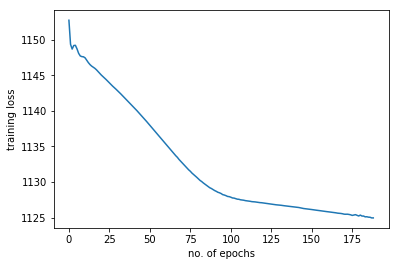

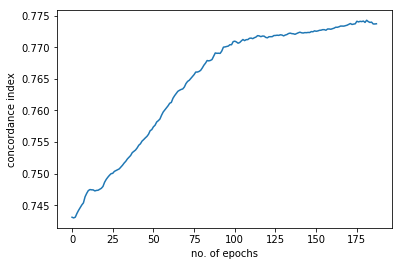

In [65]:
# Print the final metrics
# print('Train C-Index:', metrics['c-index'])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

print("num of epochs: ", len(metrics['train_loss']))
# print(metrics['train_loss'])
# Plot the training / validation curves
plt.plot(range(len(metrics['train_loss'])), metrics['train_loss'])
plt.xlabel('no. of epochs')
plt.ylabel('training loss')
plt.show()

plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.xlabel('no. of epochs')
plt.ylabel('concordance index')
# plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.show()

In [52]:
print(metrics['c-index'][-1])

0.7763382951652223
